In [9]:
from pathlib import Path
from collections import defaultdict
from typing import Dict, List
import numpy as np
np.int = int
import pretty_midi
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Processing Beethoven:   5%|▌         | 11/213 [00:00<00:06, 29.85it/s]

Error reading ..\data\midi\archive\midiclassics\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Processing Mozart:  48%|████▊     | 123/257 [00:10<00:07, 16.77it/s]

Error reading ..\data\midi\archive\midiclassics\Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


Processing Mozart: 100%|██████████| 257/257 [00:22<00:00, 11.22it/s]



Bach: 1024 files
  Min notes: 9
  Max notes: 17389
  Mean notes: 444.4
  Median notes: 143.0

Beethoven: 212 files
  Min notes: 16
  Max notes: 9912
  Mean notes: 1530.4
  Median notes: 1060.0

Chopin: 136 files
  Min notes: 61
  Max notes: 8865
  Mean notes: 1466.6
  Median notes: 928.0

Mozart: 256 files
  Min notes: 51
  Max notes: 8980
  Mean notes: 1181.7
  Median notes: 625.5


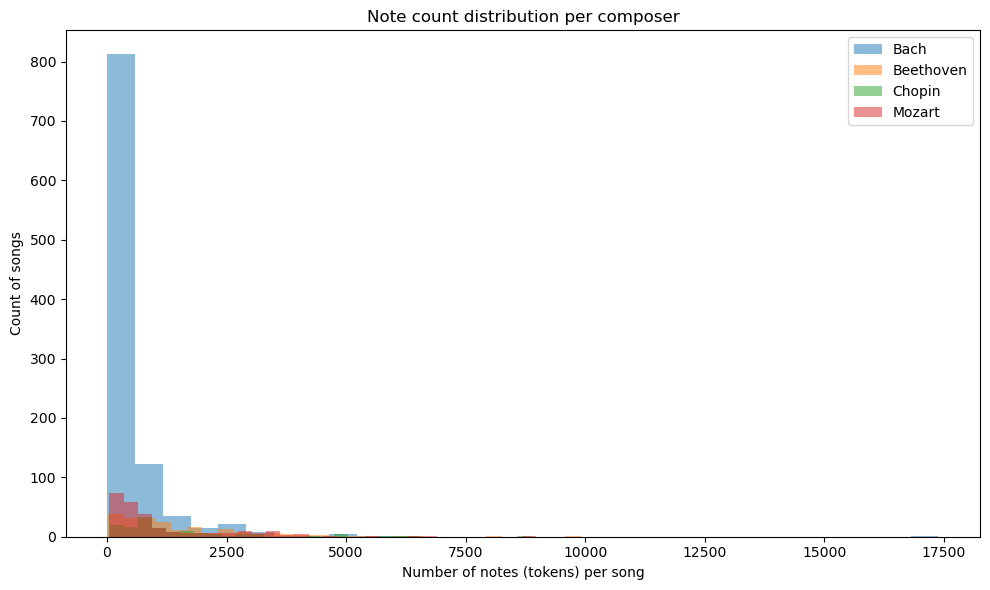

In [ ]:
#  Config you can tweak 
dataset_folder = Path("../data/midi/archive/midiclassics")
target_composers = ["Bach", "Beethoven", "Chopin", "Mozart"]

# A dict like {"Bach": [count1, count2, ...], ...}
note_counts: Dict[str, List[int]] = defaultdict(list)


def count_notes(file_path: Path) -> int:
    """
    Return the number of pitched notes in the FIRST non-drum instrument.
    If file can't be parsed, we log and return 0.
    """
    try:
        midi = pretty_midi.PrettyMIDI(str(file_path))

        # Find the first non-drum instrument that actually has notes.
        for instrument in midi.instruments:
            if not instrument.is_drum and instrument.notes:
                return len(instrument.notes)

        # If we got here, either there were only drums or no notes at all.
        return 0

    except Exception as e:
        # Keep going even if one file is messy or corrupt.
        print(f"Error reading {file_path}: {e}")
        return 0


#Scan folders and count notes per file 
for composer in target_composers:
    composer_folder = dataset_folder / composer
    # Grab both .mid and .midi files (recursive), then sort for repeatability.
    midi_files = sorted(
        list(composer_folder.rglob("*.mid")) + list(composer_folder.rglob("*.midi"))
    )

    for file_path in tqdm(midi_files, desc=f"Processing {composer}"):
        n = count_notes(file_path)
        if n > 0:  # ignore empty/invalid files so stats aren't skewed by zeros
            note_counts[composer].append(n)

# Print summary stats
for composer, counts in note_counts.items():
    counts_arr = np.asarray(counts)
    if counts_arr.size == 0:
        print(f"\n{composer}: 0 usable files")
        continue

    print(f"\n{composer}: {counts_arr.size} files")
    print(f"  Min notes: {counts_arr.min()}")
    print(f"  Max notes: {counts_arr.max()}")
    print(f"  Mean notes: {counts_arr.mean():.1f}")
    print(f"  Median notes: {np.median(counts_arr):.1f}")

#Plot distributions per composer 
plt.figure(figsize=(10, 6))
for composer, counts in note_counts.items():
    if counts:  # only plot if we have data
        plt.hist(counts, bins=30, alpha=0.5, label=composer)

plt.xlabel("Number of notes (tokens) per song")
plt.ylabel("Count of songs")
plt.title("Note count distribution per composer")
plt.legend()
plt.tight_layout()
plt.show()


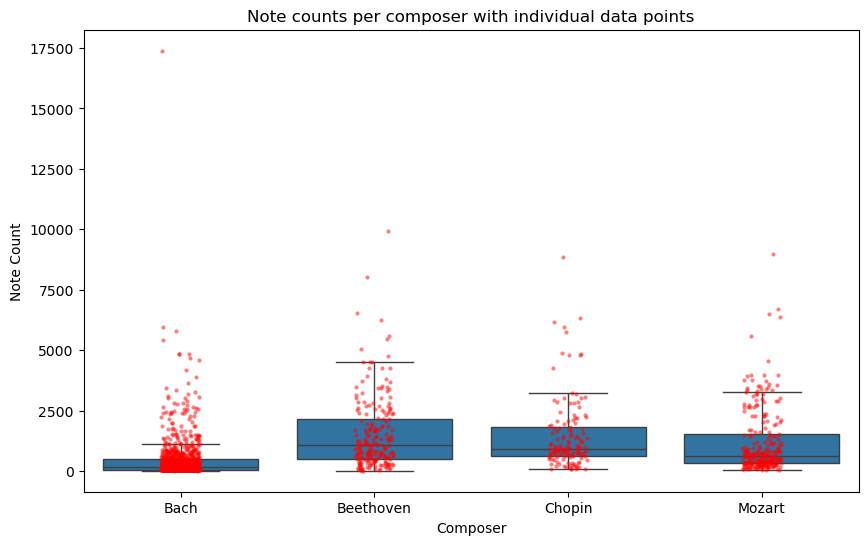

In [14]:
import pandas as pd
import seaborn as sns

# Convert note_counts dict to DataFrame
counts_df = pd.DataFrame([
    {"Composer": comp, "Note Count": cnt}
    for comp, counts in note_counts.items()
    for cnt in counts
])

plt.figure(figsize=(10, 6))
sns.boxplot(data=counts_df, x="Composer", y="Note Count", showfliers=False)
sns.stripplot(data=counts_df, x="Composer", y="Note Count", 
              color='red', size=3, jitter=True, alpha=0.5)  # overlay points
plt.title("Note counts per composer with individual data points")
plt.show()


### KDE
Kernel Density Estimates let us see style overlap between composers.


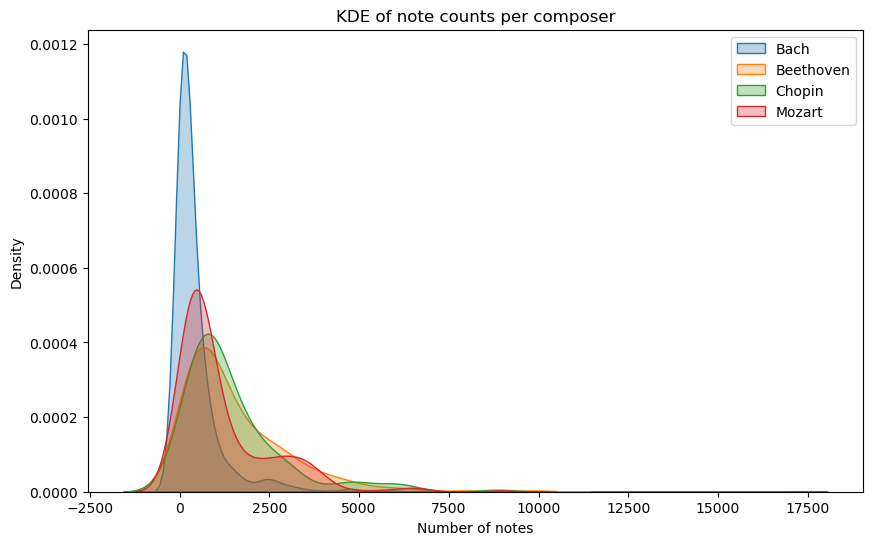

In [11]:

plt.figure(figsize=(10, 6))
for composer, counts in note_counts.items():
    sns.kdeplot(counts, label=composer, fill=True, alpha=0.3)
plt.xlabel("Number of notes")
plt.ylabel("Density")
plt.title("KDE of note counts per composer")
plt.legend()
plt.show()
